# About 

This Colab notebook is for a manuscript that is in the works. 


In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
%cd /content/gdrive/MyDrive/Git/ProtoShotXAI-1/

/content/gdrive/MyDrive/Git/ProtoShotXAI-1


In [18]:
!python setup.py develop

running develop
running egg_info
writing ProtoShotXAI.egg-info/PKG-INFO
writing dependency_links to ProtoShotXAI.egg-info/dependency_links.txt
writing top-level names to ProtoShotXAI.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'ProtoShotXAI.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/ProtoShotXAI.egg-link (link to .)
ProtoShotXAI 1.0 is already the active version in easy-install.pth

Installed /content/gdrive/MyDrive/Git/ProtoShotXAI-1
Processing dependencies for ProtoShotXAI==1.0
Finished processing dependencies for ProtoShotXAI==1.0


# Imports, Program Constants and Data Preparation 

This section of the notebook prepares the MNIST dataset. We force all the networks to use an `input_shape=(28,28,1)`. 

In [19]:
import os
import tqdm
import pickle
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist

import matplotlib as mat
import matplotlib.pylab as plt 

from architectures.protoshotxai import ProtoShotXAI
from utils.ploting_function import xai_plot

plt.style.use('ggplot')

In [20]:
# shape of the mnist dataset 
input_shape = (28, 28, 1)
# number of classes 
num_classes = 10
# number of shots 
shot = 5
# DPI for the plots 
DPI = 1000
# adversarial paths 
path_adversarial_dataset = '/content/gdrive/MyDrive/Data/MNIST_adversarial.pkl'
# file name identifier and network to use 
# models/mnist_vgg16.h5, trained_models/adv_pretrained_conv_mnist/, models/mnist_vgg16_v2.h5, models/mnist_cnn.h5
identifier = 'cnn'
path_model_pretrained = 'models/mnist_cnn.h5'

In [21]:
base_model = load_model(path_model_pretrained)

# load the mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = np.expand_dims(x_train,axis = 3)/255, np.expand_dims(x_test,axis=3)/255

data = pickle.load(open(path_adversarial_dataset, 'rb'))
x_test_adv, y_test_adv = data['x_test_adv'], data['y_test_adv']

example_index = 3495  # 3495
query_adv = np.expand_dims(x_test_adv[example_index,:,:,0], axis=2)
query_adv = np.expand_dims(query_adv, axis=0)
query_adv = np.expand_dims(query_adv, axis=0)

adv_sample = x_test_adv[example_index,:,:,:]
adv_samples = np.tile(np.expand_dims(np.copy(adv_sample),axis=0), (10000,1,1,1))
adv_sum = np.sum(np.abs(adv_samples-x_test), axis=(1,2,3))
adv_where = np.where(adv_sum == np.min(adv_sum))[0][0]

query_benign = np.expand_dims(x_test[adv_where,:,:,0], axis=2)
query_benign = np.expand_dims(query_benign, axis=0)
query_benign = np.expand_dims(query_benign, axis=0)

(-0.5, 27.5, 27.5, -0.5)

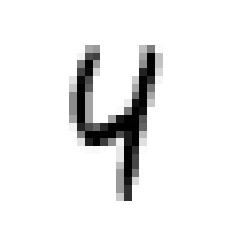

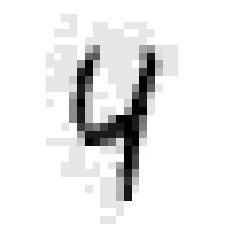

In [22]:
plt.figure()
plt.imshow(1-x_test[adv_where,:,:,0], 'gray')
plt.axis('off')
plt.figure()
plt.imshow(1-x_test_adv[example_index,:,:,0], 'gray')
plt.axis('off')

In [23]:
protoshot = ProtoShotXAI(base_model)

In [24]:
print('Prediction adversarial: ', np.argmax(base_model.predict(query_adv[0])))
print('Prediction benign:      ', np.argmax(base_model.predict(query_benign[0])))

Prediction adversarial:  4
Prediction benign:       4


In [25]:
## Adversarial 4, prototype 4
iclass = 4 # prototype 4
support_data = x_train[y_train == iclass]
support_data = support_data[np.random.permutation(support_data.shape[0])[:shot]]
support_data = np.expand_dims(np.copy(support_data), axis=0)

s_feature_adv_proto4, q_feature_adv_proto4, den = protoshot.compute_features(support_data, query_adv, iclass)
s_feature_adv_proto4 = s_feature_adv_proto4.flatten()
q_feature_adv_proto4 = q_feature_adv_proto4.flatten()
den_adv_proto4 = den[0][0]

## Benign 4, prototype 4
s_feature_benign_proto4, q_feature_benign_proto4, den = protoshot.compute_features(support_data, query_benign, iclass)
s_feature_benign_proto4 = s_feature_benign_proto4.flatten()
q_feature_benign_proto4 = q_feature_benign_proto4.flatten()
den_benign_proto4 = den[0][0]

## Adversarial 4, prototype 5
iclass = 5 # prototype 4
support_data = x_train[y_train == iclass]
support_data = support_data[np.random.permutation(support_data.shape[0])[:shot]]
support_data = np.expand_dims(np.copy(support_data),axis=0)

s_feature_adv_proto5, q_feature_adv_proto5, den = protoshot.compute_features(support_data, query_adv, iclass)
s_feature_adv_proto5 = s_feature_adv_proto5.flatten()
q_feature_adv_proto5 = q_feature_adv_proto5.flatten()
den_adv_proto5 = den[0][0]

## Benign 4, prototype 5
s_feature_benign_proto5, q_feature_benign_proto5, den = protoshot.compute_features(support_data, query_benign, iclass)
s_feature_benign_proto5 = s_feature_benign_proto5.flatten()
q_feature_benign_proto5 = q_feature_benign_proto5.flatten()
den_benign_proto5 = den[0][0]

f = np.linspace(0, s_feature_adv_proto4.shape[0], s_feature_adv_proto4.shape[0])


In [ ]:
# 
plt.figure(dpi=DPI)
plt.plot(f, s_feature_adv_proto4/np.sqrt(np.sum(s_feature_adv_proto4*s_feature_adv_proto4)), 
         c='r', marker='o', label='Support Features')
plt.plot(f, q_feature_adv_proto4/np.sqrt(np.sum(q_feature_adv_proto4*q_feature_adv_proto4)), 
         c='b', marker='p', label='Query Features')
plt.xlim([0, 128])
plt.ylim([-.5, .5])
plt.xlabel('Feature Index')
plt.ylabel('Feature Weight')
plt.legend()
plt.title('Class 4 Features for Adversarial 4')
plt.savefig(''.join(['outputs/WeightPlot_Class4_Adversarial4_', identifier, '.pdf']))

# 
plt.figure(dpi=DPI)
plt.plot(f, s_feature_benign_proto4/np.sqrt(np.sum(s_feature_benign_proto4*s_feature_benign_proto4)), 
         c='r', marker='o', label='Support Features')
plt.plot(f, q_feature_benign_proto4/np.sqrt(np.sum(q_feature_benign_proto4*q_feature_benign_proto4)), 
         c='b', marker='p', label='Query Features')
plt.xlim([0, 128])
plt.ylim([-.5, .5])
plt.legend()
plt.title('Class 4 Features for Benign 4')
plt.savefig(''.join(['outputs/WeightPlot_Class4_Benign4_', identifier, '.pdf']))

# 
plt.figure(dpi=DPI)
plt.plot(f, s_feature_adv_proto5/np.sqrt(np.sum(s_feature_adv_proto5*s_feature_adv_proto5)), 
         c='r', marker='o', label='Support Features')
plt.plot(f, q_feature_adv_proto5/np.sqrt(np.sum(q_feature_adv_proto5*q_feature_adv_proto5)), 
         c='b', marker='p', label='Query Features')
plt.xlim([0, 128])
plt.ylim([-.5, .5])
plt.legend()
plt.title('Class 4 Features for Adversarial 5')
plt.savefig(''.join(['outputs/WeightPlot_Class5_Adversarial5_', identifier, '.pdf']))

# 
plt.figure(dpi=DPI)
plt.plot(f, s_feature_benign_proto5/np.sqrt(np.sum(s_feature_benign_proto5*s_feature_benign_proto5)), 
         c='r', marker='o', label='Support Features')
plt.plot(f, q_feature_benign_proto5/np.sqrt(np.sum(q_feature_benign_proto5*q_feature_benign_proto5)), 
         c='b', marker='p', label='Query Features')
plt.xlim([0, 128])
plt.ylim([-.5, .5])
plt.legend()
plt.title('Class 4 Features for Benign 5')
plt.savefig(''.join(['outputs/WeightPlot_Class4_Benign5_', identifier, '.pdf']))


In [ ]:
n_samples = 1000
rand_seq = np.random.permutation(np.shape(x_test_adv)[0])
rand_seq = rand_seq[:n_samples]
scores_benign = np.zeros((n_samples,10))
scores_adv = np.zeros((n_samples,10))
true_vals = np.zeros(n_samples)

progress_bar = True
for irand in tqdm.tqdm(range(n_samples),disable=(not progress_bar)):
    rand_int = rand_seq[irand] 
    true_vals[irand] = y_test[rand_int]
    
    query_adv = np.expand_dims(x_test_adv[rand_int,:,:,0], axis=2)
    query_adv = np.expand_dims(query_adv, axis=0)
    query_adv = np.expand_dims(query_adv, axis=0)

    query_benign = np.expand_dims(x_test[rand_int,:,:,0], axis=2)
    query_benign = np.expand_dims(np.copy(query_benign), axis=0)
    query_benign = np.expand_dims(np.copy(query_benign), axis=0)

    for iclass in range(10):
        support_data = x_train[y_train == iclass]
        support_data = support_data[np.random.permutation(support_data.shape[0])[:shot]]
        support_data = np.expand_dims(np.copy(support_data), axis=0)
        scores_adv[irand, iclass] = protoshot.compute_score(support_data,query_adv, iclass)
        scores_benign[irand, iclass] = protoshot.compute_score(support_data,query_benign, iclass)


In [28]:
mask_adv = np.zeros((n_samples,10))
mask_adv[np.arange(n_samples), np.argmax(scores_adv,axis=1)] = 1

mask_benign = np.zeros((n_samples,10))
mask_benign[np.arange(n_samples), true_vals.astype(int)] = 1

in_class_benign = scores_benign[mask_benign==1]
in_class_adv = scores_adv[mask_adv==1]

In [ ]:
plt.figure(dpi=DPI)
plt.hist(in_class_benign, density=True, alpha=.5, bins=15, label='Benign')
plt.hist(in_class_adv, density=True, alpha=.5, bins=15, label='Adversarial')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.savefig(''.join(['outputs/Adversarial_MNIST_Histrograms_', identifier, '.pdf']))


In [ ]:
n_points = 1000
thresh = np.arange(n_points)/n_points
ROC_x = np.zeros_like(thresh)
ROC_y = np.zeros_like(thresh)
for i in range(n_points):
    ithresh = thresh[i]
    ROC_y[i] = np.sum(in_class_benign >= ithresh)/n_points
    ROC_x[i] = np.sum(in_class_adv >= ithresh)/n_points


plt.figure(dpi=DPI)
plt.plot(ROC_x, ROC_y)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig(''.join(['outputs/Adversarial_MNIST_ROC_', identifier, '.pdf']))
